# Complexifying a binary image

The first step to compute the Euler Characteristic Transform, is to make a cubical complex out of our image (either 2D or 3D.) As stated by Robins et al. [(2011)](https://doi.org/10.1109/TPAMI.2011.95), a cubical complex represents faithfully the topology of a digital image. We treat each pixel/voxel as an individual vertes. If two pixels share a border, we draw an edge between them. A block of $2\times2$ pixels forms a square. A block of $2\times2\times2$ voxels forms a cube. Refer to the figure below.

<img src=https://www.egr.msu.edu/~amezqui3/barley/figs/cubical_complex.png width="500">

The code below walks through the main bits of the `complexify` function, which works with both 2D and 3D images. In principle it can actually handle $N$-dimensional images.

***

## Load the necessary libraries

In [5]:
import tifffile as tf
import numpy as np
import os
import argparse
import glob
import math
import importlib
import time
import itertools
import pandas as pd
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
import scipy.special as special

import demeter.misc as misc

## Load an image

- Make sure the image is black and white
- From now on by pixel we mean nonzero-valued pixel
- We'll treat zero-valued pixels as nonexistent.
- For our example, we'll work with a leaf scan. Courtesy of [Alexander White](http://www.alexwhitebiology.com/) and [Rebecca Dikow](https://datascience.si.edu/people/dr-rebecca-dikow).

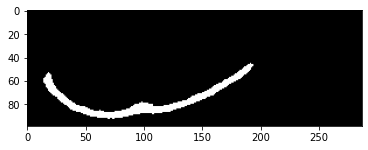

In [2]:
leaf = '../petiole/col-0_pot_0/col-0_comp_0.tif'
src, fname = os.path.split(leaf)
bname = os.path.splitext(fname)[0]
img = tf.imread(leaf)
img[img > 0] = 1

struc = ndimage.generate_binary_structure(img.ndim, 1)
its = 1

img = ndimage.binary_fill_holes(img)
img = ndimage.binary_erosion(img, iterations=its, structure=struc)
img = ndimage.binary_dilation(img, iterations=its+1, structure=struc)

plt.imshow(img[:,130,:], cmap='gray');

In [22]:
border = np.array([[[0,0,0],[0,-1,0],[0,0,0]],
                  [[0,-1,0],[-1,6,-1],[0,-1,0]],
                  [[0,0,0],[0,-1,0],[0,0,0]]])

border = np.zeros_like(border) - 1
border[1,1,1] = 26

surface = ndimage.convolve(img, border, np.int8, 'constant', cval=0)

surface[ surface < 0 ] = 0
surface[ surface > 0 ] = 1

scoords = np.nonzero(surface)
scoords = np.vstack(scoords).T
print(len(scoords))

downsample = 2
skip = np.array([downsample,downsample,downsample])
coords = scoords[np.all(np.fmod(scoords, skip) == 0, axis=1), :]

print(len(coords))

keys = [tuple(coords[i,:]) for i in range(len(coords))]
dcoords = dict(zip(keys, range(len(coords))))

95900
11986


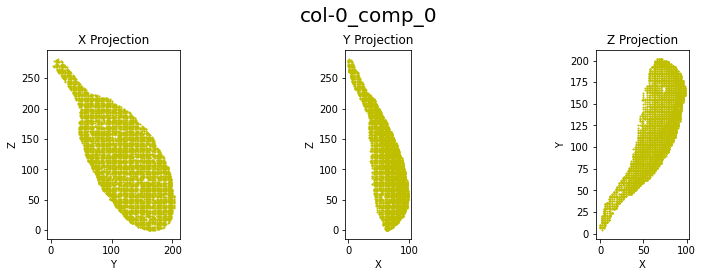

In [6]:
misc.plot_3Dprojections(coords, bname)

## Label the vertices

- Write a dictionary `dcoords` where each non-zero pixel gets a unique label. 
- Dictionary keys are the $x,y,(z)$ coordinates of the pixels
- Dictionary labels are $1,\ldots,N$.

In [ ]:
scoords = np.nonzero(img)
scoords = np.vstack(scoords).T
print(len(scoords))

downsample = 4
skip = np.array([downsample,downsample,downsample])
coords = scoords[np.all(np.fmod(scoords, skip) == 0, axis=1), :]

keys = [tuple(coords[i,:]) for i in range(len(coords))]
dcoords = dict(zip(keys, range(len(coords))))

print(len(dcoords))

```
dcoords

{(8, 269): 0,
 (8, 270): 1,
 (9, 268): 2,
 (9, 269): 3,
 (9, 270): 4,
 ```

## Setup the neighborhood to check for each pixel.

- The neighborhood `neighs` of each pixel consists of the pixels north (`(0,1)`), east (`(1,0)`), and northeast (`(1,1,)`). 
- Each neighbor is numbered:
    - Original pixel: 0
    - North neighbor: 1
    - East neighbor: 2
    - Northeast neighbor: 3
- Later we determine `subtuples` of which neighbors need to exist to draw edges, faces, and cubes between them.
- For instance, a square `(0,0) -- (1,0) -- (1,1) -- (0,1)` will be drawn only if the original pixel and its three neighbors (`[0,1,2,3]`) are all nonzero.
- By **not** checking the full 8-neighborhood, we guarantee that there won't be duplicate edges, faces, or cubes.

In [ ]:
dimension = 3
neighs = sorted(list(itertools.product(range(2), repeat=dimension)), key=np.sum)[1:]
neighs
#foo

In [8]:
def neighborhood_setup(dimension, downsample = 1):
    neighs = sorted(list(itertools.product(range(2), repeat=dimension)), key=np.sum)[1:]
    neighs = list(map(tuple, np.array(neighs)*downsample))
    subtuples = dict()
    for i in range(len(neighs)):
        subtup = [0]
        for j in range(len(neighs)):
            if np.all(np.subtract(neighs[i], neighs[j]) > -1):
                subtup.append(j+1)
        subtuples[neighs[i]] = subtup

    return neighs, subtuples

In [9]:
neighs, subtuples = neighborhood_setup(img.ndim, downsample)
#neighs = np.array(neighs)*downsample
print(neighs, subtuples, sep='\n\n')

[(0, 0, 2), (0, 2, 0), (2, 0, 0), (0, 2, 2), (2, 0, 2), (2, 2, 0), (2, 2, 2)]

{(0, 0, 2): [0, 1], (0, 2, 0): [0, 2], (2, 0, 0): [0, 3], (0, 2, 2): [0, 1, 2, 4], (2, 0, 2): [0, 1, 3, 5], (2, 2, 0): [0, 2, 3, 6], (2, 2, 2): [0, 1, 2, 3, 4, 5, 6, 7]}


In [10]:
binom = [special.comb(img.ndim, k, exact=True) for k in range(img.ndim+1)]
binom

[1, 3, 3, 1]

- It's worth noting that the same logic applies for 3D images

In [17]:
n, s = neighborhood_setup(3)
n = 
print(n,s, sep='\n\n')

[(0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1)]

{(0, 0, 1): [0, 1], (0, 1, 0): [0, 2], (1, 0, 0): [0, 3], (0, 1, 1): [0, 1, 2, 4], (1, 0, 1): [0, 1, 3, 5], (1, 1, 0): [0, 2, 3, 6], (1, 1, 1): [0, 1, 2, 3, 4, 5, 6, 7]}


## Determine the labels of the neighborhood

- Given an initial pixel (or `voxel`), determine the labels of the neighbors
- If a neighbor is zero-valued, it gets labeled as `-1`

In [11]:
def neighborhood(voxel, neighs, hood, dcoords):
    hood[0] = dcoords[voxel]
    neighbors = np.add(voxel, neighs)
    for j in range(1,len(hood)):
        key = tuple(neighbors[j-1,:])
        if key in dcoords:
            hood[j] = dcoords[key]
    return hood

- Below we compute the neighborhood labels for the 55th pixel
- Based from `neighborhood_setup`, we can read it as follows
```
[55 56 68 -1]
```
    - The initial pixel is labeled as 55 (as expected)
    - The 56th pixel is the north neighbor
    - The 68th pixel is the east neighbor
    - There is no northeast neighbor

In [12]:
hood = np.zeros(len(neighs)+1, dtype=np.int)-1
voxel = keys[60]
hood = neighborhood(voxel, neighs, hood, dcoords)
print(voxel, '\n', hood)

(4, 24, 254) 
 [60 61 66 -1 67 -1 -1 -1]


## Draw edges, faces, and cubes based on the neighborhood

- As stated in `neighborhood_setup`, we check subsets of neighbors to determine if we need to draw edges, faces or cubes.
- For our example, we have to draw north and east edges.
- We keep track of our edges by recording the labels corresponding to the pixels on the ends
    - `[55, 56]`
    - `[55, 68]`
- Since there is no northeast neighbor, no square is recorded.
- Since this is a 2D image, no cubes are recorded
- Vertices will be added later

In [16]:
np.nonzero(hood[1:-1] > -1)[0]

array([0, 1, 3])

In [ ]:
binom = [special.comb(img.ndim, k, exact=True) for k in range(img.ndim+1)]
cells = [[] for k in range(img.ndim+1)]
nhood = hood > -1

c = 0
for k in range(1, img.ndim):
    for j in range(binom[k]):
        cell = hood[subtuples[neighs[c]]]
        if np.all(cell > -1):
            cells[k].append(hood[subtuples[neighs[c]]])
        c += 1
if nhood[-1]:
    cells[img.ndim].append(hood.copy())
cells

## Check the neighborhood of every pixel

- We repeat the same idea, but for all pixels
- In 2D, the cubical complex `cells` is list of 3 arrays
    - **Vertices**: `cells[0]`: An $N_0\times2$ array with the pixel $(x,y)$ _centered_ coordinates.
    - **Edges**: `cells[1]`: An $N_1\times2$ array. Every edge is determined by the labels of their ends.
    - **Squares**: `cells[2]`: An $N_2\times4$ array. Every square is determined by the labels of their corners.
- For 3D, the cubical complex follows the same logic, adding
    - **Cubes**: `cells[3]`: An $N_3\times8$ array. Every cube is determined by the labels of their corners.

- The full function is available in the `utils` script.
- For a $d$-dimensional image, the running time is in principle $O(2^dN)$ on $N$ voxels.
    - Although we have a couple of small speedups whenever we have a similar number of cubes and vertices.

## Putting everything together into `demeter.euler`

- The `demeter.euler` submodule defines the class `CubicalComplex`
- The first step is to complexify the given image `img`
    - `complexify()` takes one parameter: `center` (boolean : `True` by default)
        - The Cartesian coordinates of the cubical complex will be centered
- The `CubicalComplex` contains attributes
    - `.img`: original `img` array
    - `.cells`: arrays with cells information
    - `.chi`: Euler characteristic

In [18]:
import demeter.euler as euler

In [23]:
tic = time.perf_counter()
Cells = euler.CubicalComplex(surface).complexify(center=True, downsample=1)
toc = time.perf_counter()

print("Complexify in {:.4f} seconds.\n\nCubical complex made of:".format(toc-tic))
Cells.summary();

Complexify in 4.6829 seconds.

Cubical complex made of:
95900	vertices
192549	edges
97497	squares
850	cubes
----
Euler Characteristic: -2


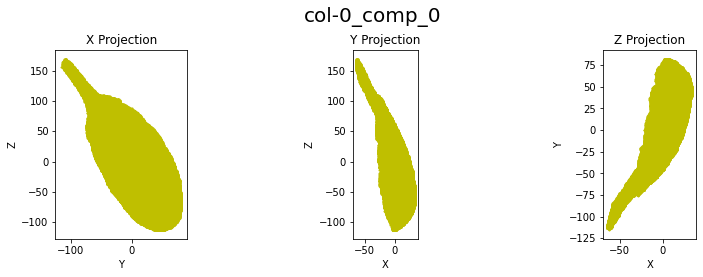

In [24]:
misc.plot_3Dprojections(Cells.cells[0], bname)

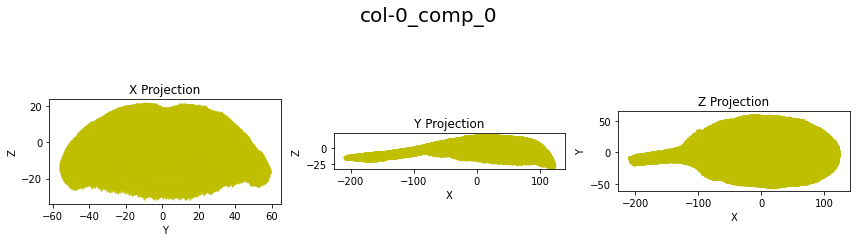

In [25]:
max_vox = misc.find_tip(Cells.cells[0], 2,1,0)
seed_coords,sigma, _, _,_ = misc.rotateSVD(Cells.cells[0], max_vox)

misc.plot_3Dprojections(seed_coords, bname)

## We can also `complexify` 3D images

In [ ]:
dst = '../petiole/coords/'


In [ ]:
Cells.cells